In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import nilearn as nl
from nilearn import plotting, image, regions, input_data, datasets, masking, surface
from nilearn.input_data import NiftiLabelsMasker
from nilearn.regions import connected_label_regions
from nilearn.masking import intersect_masks
from nistats import thresholding, reporting
from nipy import save_image, load_image
from scipy.stats import norm
from scipy.spatial import distance
import numpy as np
import scipy.io as sio
import pandas as pd
from nibabel.affines import apply_affine

# Initial Import and Inspection of Contrast Map


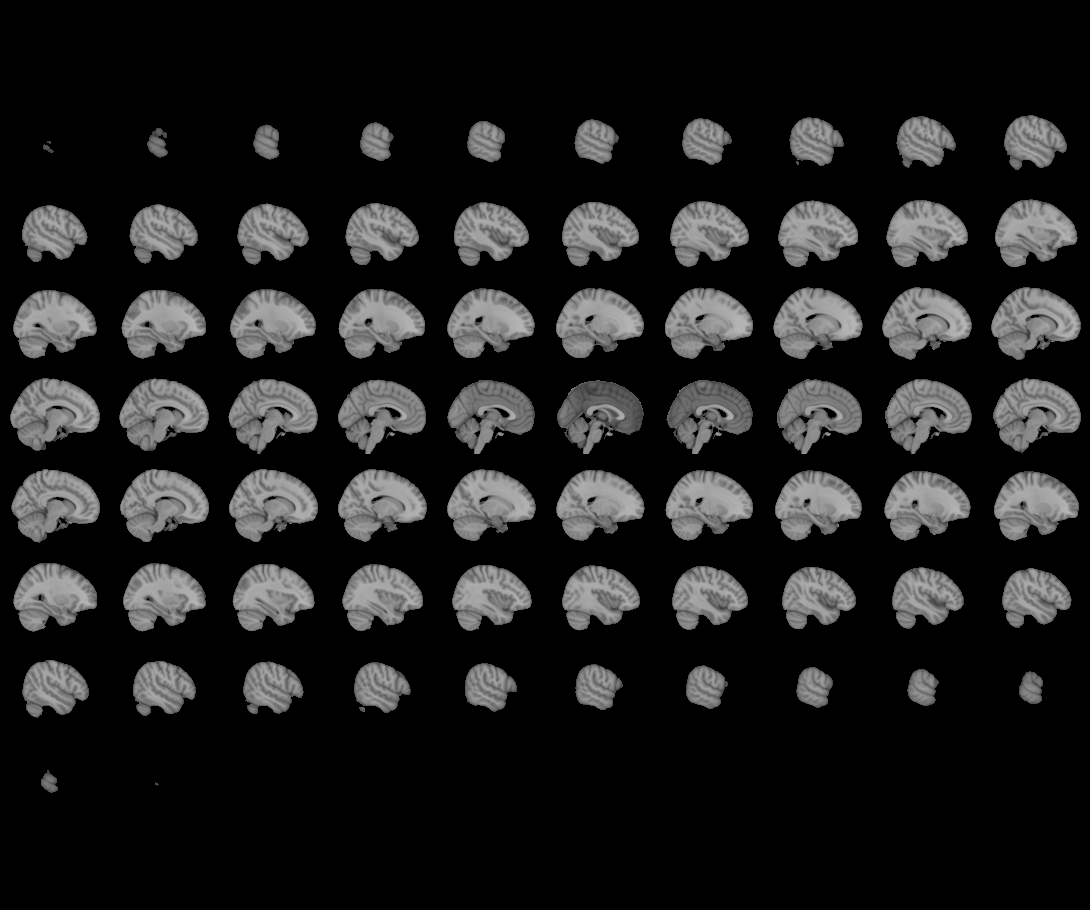
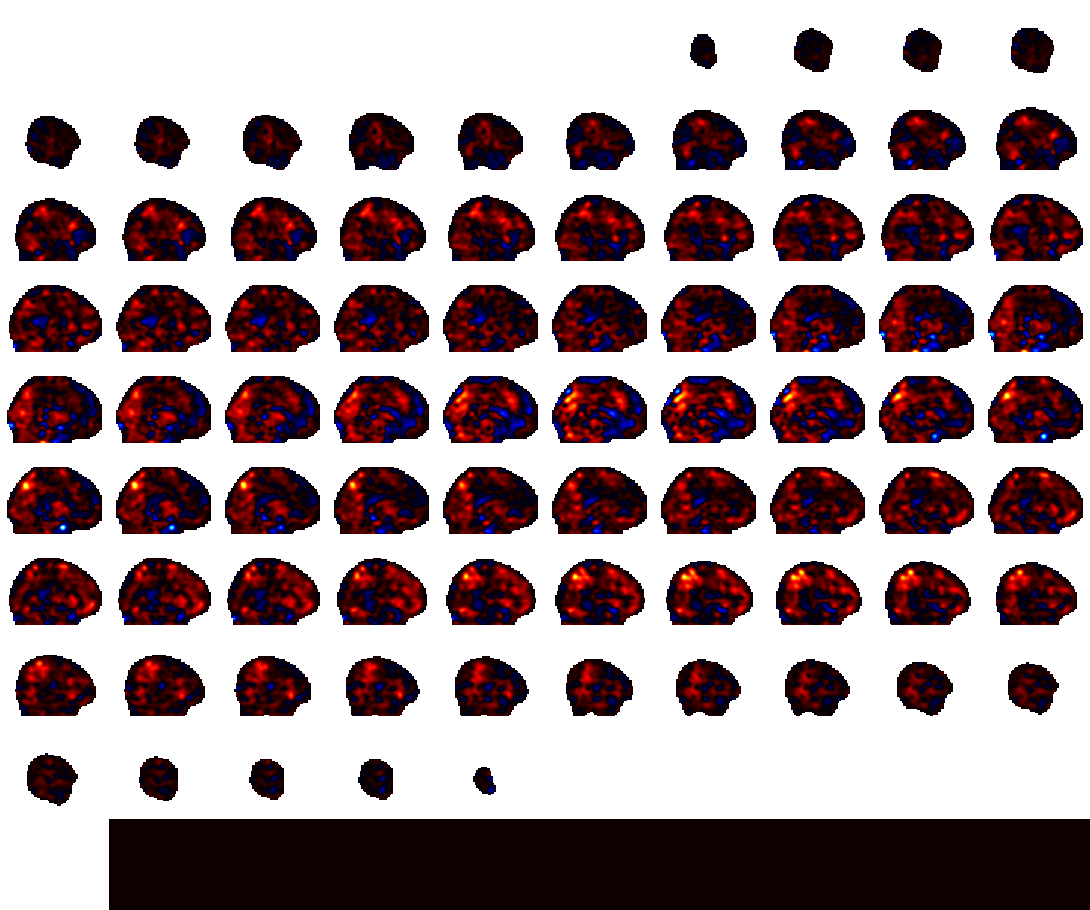

In [2]:
#Make sure that the subject number is correct!
SUBJ = 's03'
CHIAO = (53, -48, 33)
CON_DIR = '/fmriNASTest/data00/jupyterhub/bmattan@asc.upenn.edu/TMS_Target_Localizations/Contrasts'

MAP = os.path.join(CON_DIR, '{}_con_0012.nii'.format(SUBJ))
#MASK = os.path.join(CON_DIR, '{}_mask.nii'.format(SUBJ))

plotting.view_img(MAP, threshold=0, cluster_threshold=0)

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



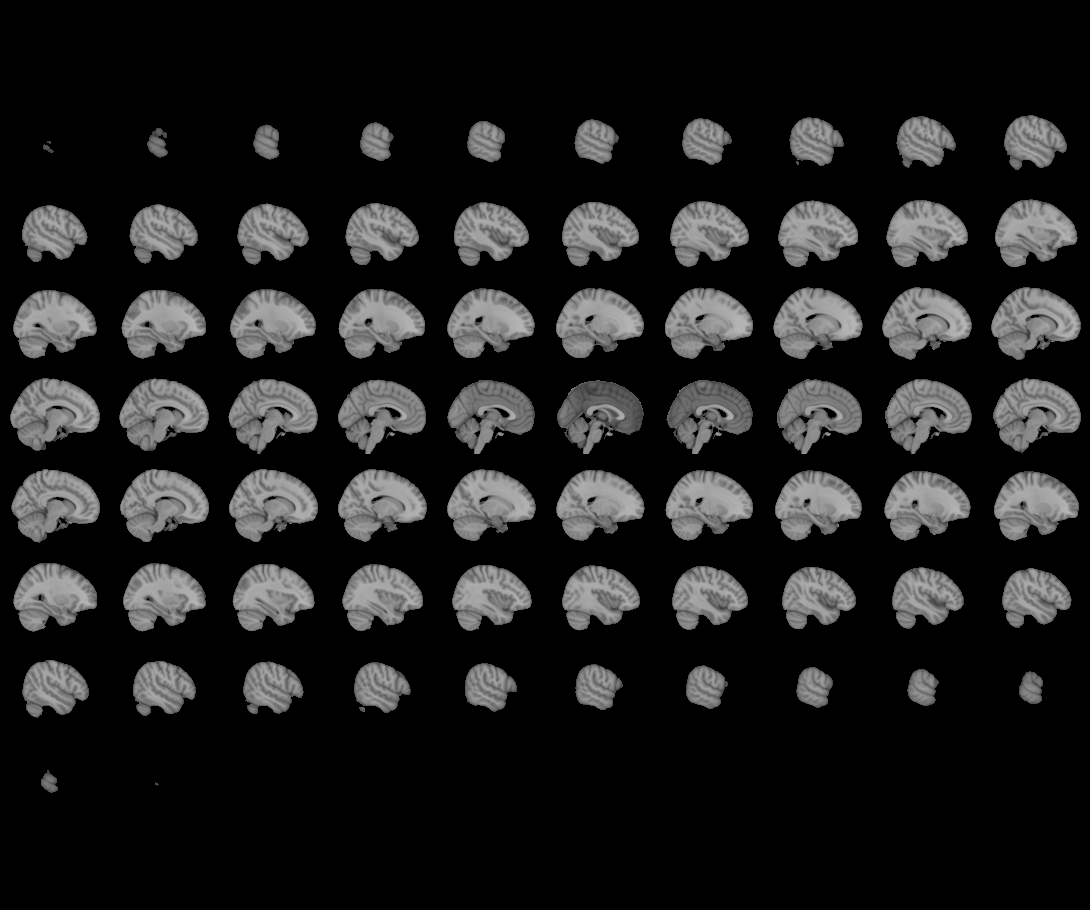
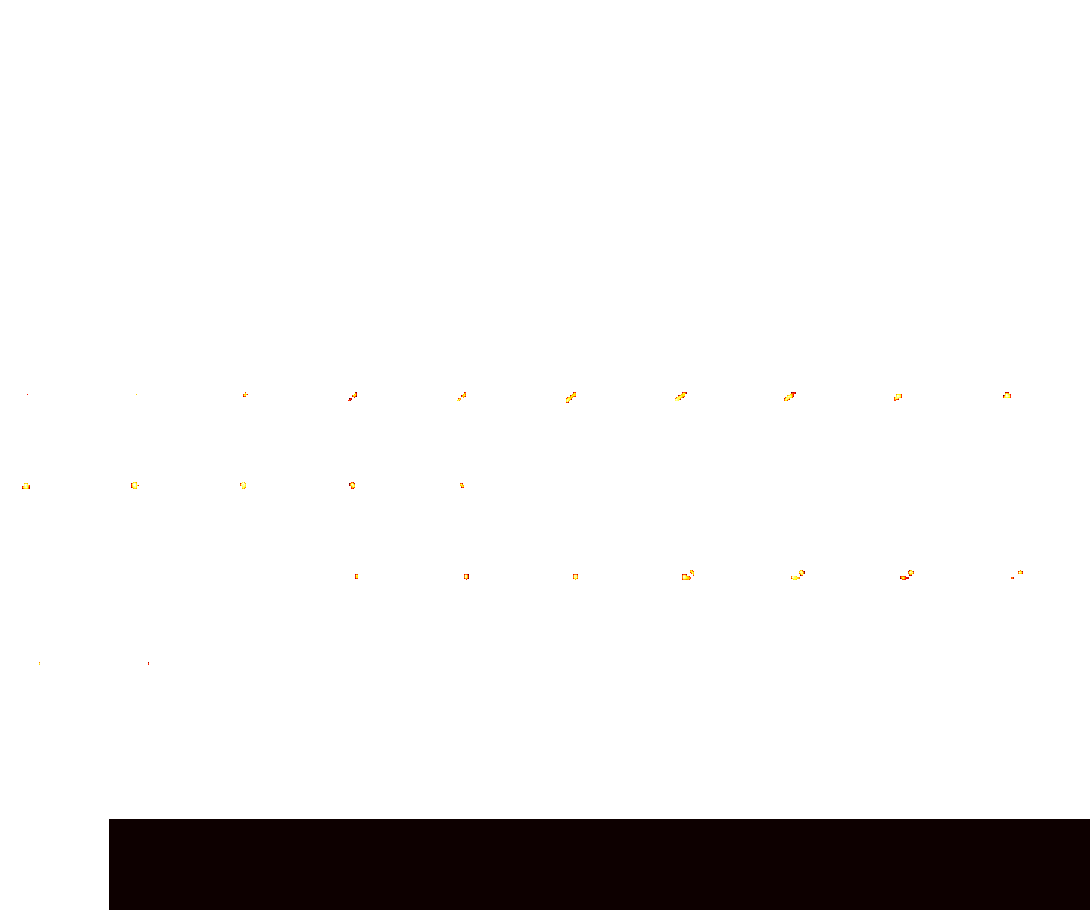

In [3]:
#Thresholding isn't necessary, but it's a little easier to look at than the previous image.
MAP_THRESH, THRESH = thresholding.map_threshold(MAP, alpha=.001, cluster_threshold=20)
plotting.view_img(MAP_THRESH)

In [4]:
#A summary of the strongest clusters
clust_table=reporting.get_clusters_table(MAP_THRESH, THRESH)
clust_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,12.0,-75.0,48.0,5.639368,3726
1,1a,0.0,-81.0,36.0,4.944490,
2,1b,-6.0,-72.0,48.0,3.837364,
3,2,42.0,-66.0,48.0,5.306149,1350
4,3,45.0,-51.0,57.0,5.133152,783


# Masking and Computing Euclidean Distances

USE: Candidate for peak location implicated in the social distance effect (close > far), social condition only
1) Chiao et al., 2009 (n=12)
    right IPS: 53, −48, 33 (confirmed that it falls within the lower half of the inferior parietal mask)
2) Yamakawa et al., 2009 (n=24) - N/A
3) Parkinson et al., 2014 (n=15) - N/A

DON'T USE: Candidates for peak locations implicated in the overlap between social and various other distances
1) Chiao et al., 2009 (n=12)
    left IPS: −48, −35, 52
    right IPS: 45, −47, 55
2) Yamakawa et al., 2009 (n=24) - I'd go with this one as it's based on the largest sample size
    left IPC: -22, -66, 54
    right IPC: 22, -70, 52
3) Parkinson et al., 2014 (n=15)
    left IPL: N/A
    right IPL: 48 -55 36 (peak coordinates from brain behavior correlations in Table 2)
    
The mask is defined from the aal atlas as the union of the inferior parietal cortex, the angular gyrus, and the supramarginal gyrus.

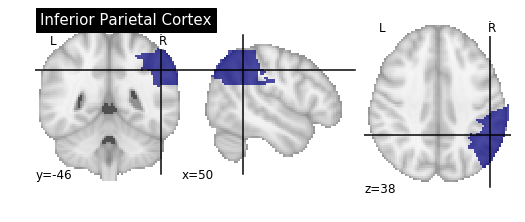

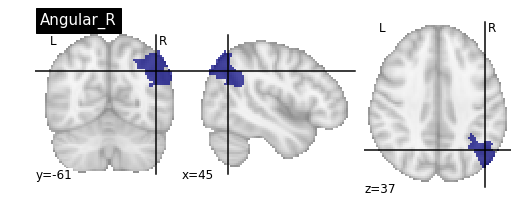

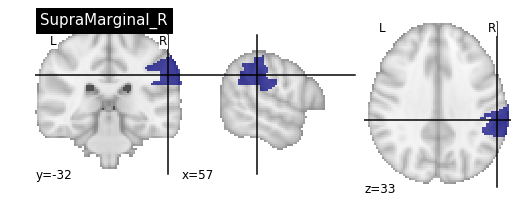

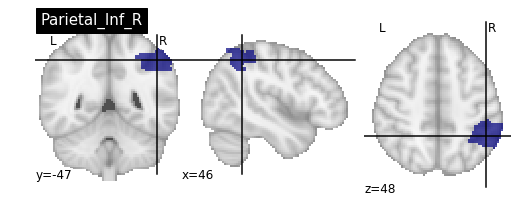

In [5]:
#1) Generate a mask for the right inferior parietal cortex from the aal atlas
    #https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_aal.html
    #https://mail.python.org/pipermail/neuroimaging/2018-January/001612.html

atlas_data = datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)

# Now find the position of each inferior parietal component in the list of region labels.
# Then, use the corresponding list of indices of the image to convert it to the index value in the map.
angular_r_idx = atlas_data.indices[atlas_data.labels.index('Angular_R')]
supramarginal_r_idx = atlas_data.indices[atlas_data.labels.index('SupraMarginal_R')]
infpar_r_idx = atlas_data.indices[atlas_data.labels.index('Parietal_Inf_R')]

# Select only the voxels of the map for which the value is equal to the this index.
rois = []
angular_r_map = image.math_img('img == %s' % angular_r_idx,
                              img=atlas_data.maps)
supramarginal_r_map = image.math_img('img == %s' % supramarginal_r_idx,
                              img=atlas_data.maps)
infpar_r_map = image.math_img('img == %s' % infpar_r_idx,
                              img=atlas_data.maps)
rois.append(angular_r_map)
rois.append(supramarginal_r_map)
rois.append(infpar_r_map)
ipc_r_map = masking.intersect_masks(rois, threshold=0, connected=True) # Creates the union of all ROIs

# Plotting the binary maps for all ROIs
plotting.plot_roi(ipc_r_map, title='Inferior Parietal Cortex')
plotting.plot_roi(angular_r_map, title='Angular_R')
plotting.plot_roi(supramarginal_r_map, title='SupraMarginal_R')
plotting.plot_roi(infpar_r_map, title='Parietal_Inf_R')

/usr/local/anaconda3/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


Shape comparison:
- Original contrast image shape : (53, 65, 53)
- Resampled contrast image shape: (91, 109, 91)
- Mask image shape              : (91, 109, 91)

Affine comparison:
- Original contrast image affine :
 [[  -3.    0.    0.   78.]
 [   0.    3.    0. -114.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
- Resampled contrast image affine:
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
- Mask image affine              :
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]



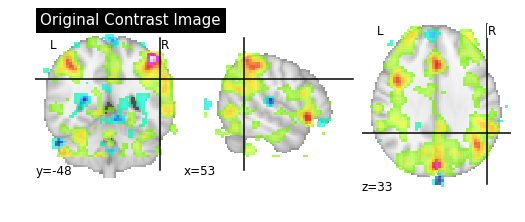

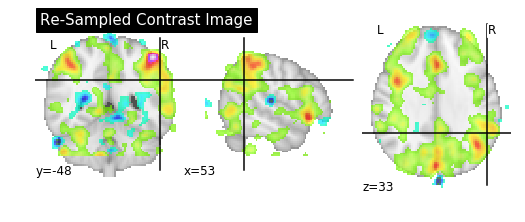

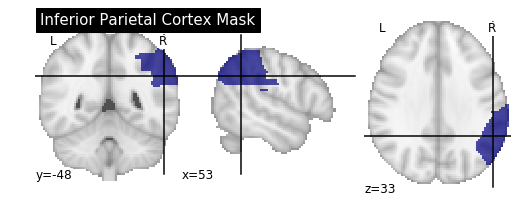

In [6]:
#2) Resample the contrast and mask images to the atlas-based mask image resolution (note all are already in MNI space).
con_img = image.load_img(MAP)
con_img_shape = con_img.shape
con_img_affine = con_img.affine

new_con_img = image.resample_to_img(con_img, ipc_r_map)
new_con_img_shape = new_con_img.shape
new_con_img_affine = new_con_img.affine

#big_mask = image.load_img(MASK)
#big_mask_shape = big_mask.shape
#big_mask_affine = big_mask.affine

#new_big_mask = image.resample_to_img(big_mask, ipc_r_map)
#new_big_mask_shape = new_big_mask.shape
#new_big_mask_affine = new_big_mask.affine

mask_shape = ipc_r_map.shape
mask_affine = ipc_r_map.affine

print("""Shape comparison:
- Original contrast image shape : {0}
- Resampled contrast image shape: {1}
- Mask image shape              : {2}
""".format(con_img_shape, new_con_img_shape, mask_shape))

print("""Affine comparison:
- Original contrast image affine :\n {0}
- Resampled contrast image affine:\n {1}
- Mask image affine              :\n {2}
""".format(con_img_affine, new_con_img_affine, mask_affine))

plotting.plot_roi(con_img, title='Original Contrast Image', display_mode='ortho', cut_coords=CHIAO)
plotting.plot_roi(new_con_img, title='Re-Sampled Contrast Image', display_mode='ortho', cut_coords=CHIAO)
#plotting.plot_roi(big_mask, title='Original Big Mask', display_mode='ortho', cut_coords=CHIAO)
#plotting.plot_roi(new_big_mask, title='Re-Sampled Big Mask', display_mode='ortho', cut_coords=CHIAO)
plotting.plot_roi(ipc_r_map, title='Inferior Parietal Cortex Mask', display_mode='ortho', cut_coords=CHIAO)


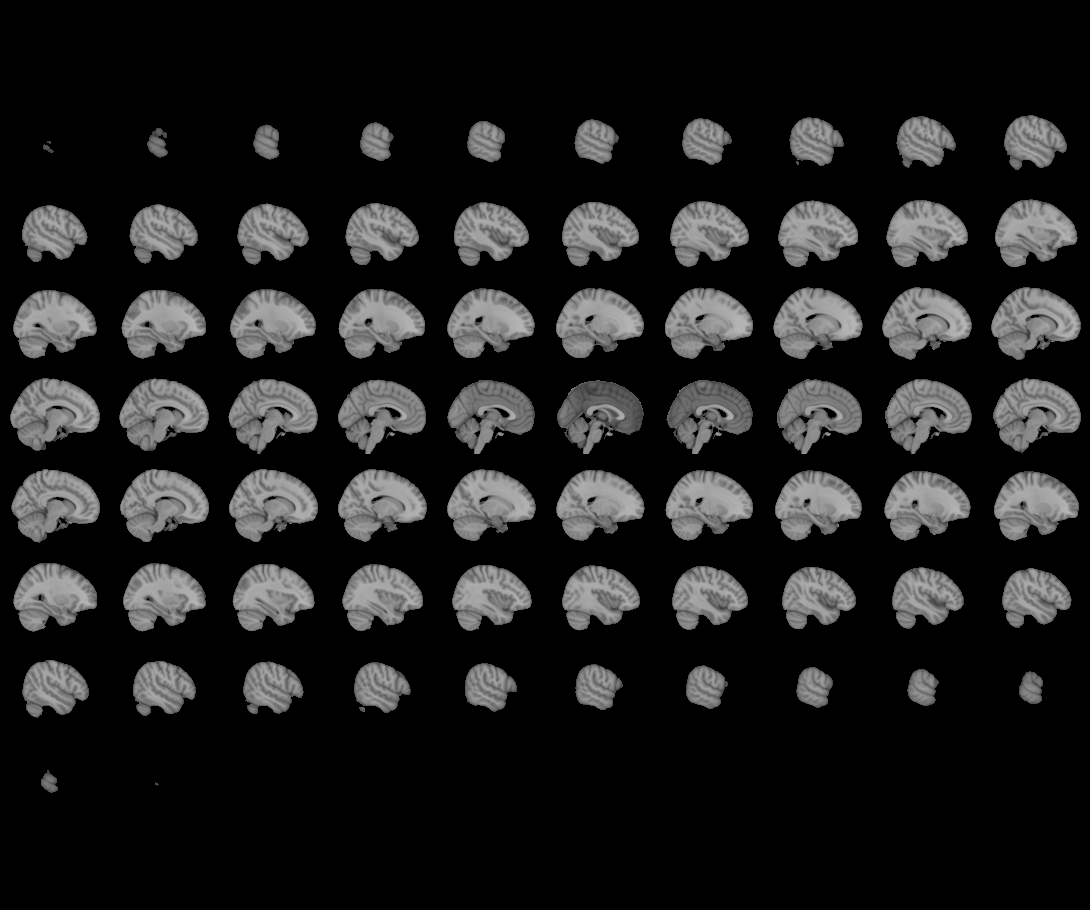
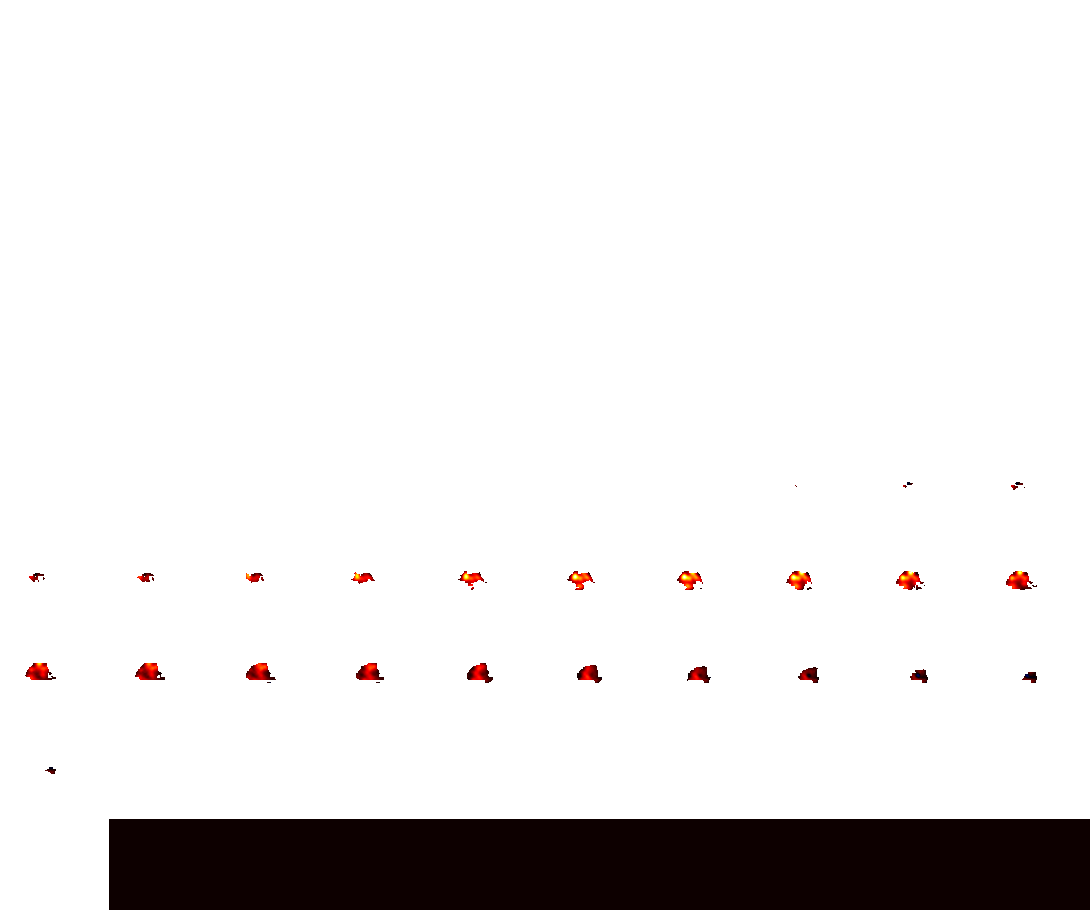

In [7]:
#3) Mask the participant's contrast image with the re-sampled mask.

MAP_masked_data = ipc_r_map.get_data() * new_con_img.get_data()
con_img_masked = image.new_img_like(new_con_img, MAP_masked_data)
plotting.view_img(con_img_masked, threshold=0, cluster_threshold=0)

In [8]:
#4) For the top cluster within the masked contrast map, generate a table containing:

# Peak Coordinates
clust_table=reporting.get_clusters_table(con_img_masked, 0)
clusters = list(clust_table['Cluster ID'])
clusters_str = []
clusters_numlist1 = range(0,len(clusters))
for c in clusters_numlist1:
    clusters_str.append(str(clusters[c]))
clusters_list = [c for c in clusters_str if c.startswith('1')]
clusters_numlist2 = range(0,len(clusters_list))
clusters_table = clust_table.iloc[clusters_numlist2,:]
    # Do it again just in case there were more than 9 clusters...
clusters_list = list(clusters_table['Cluster ID'])
clusters_str = []
for c in clusters_numlist2:
    clusters_str.append(str(clusters_list[c]))
clust1_list = [c for c in clusters_str if c.startswith('1')]
clust1_numlist = range(0,len(clust1_list))
clust1_table = clust_table.iloc[clust1_numlist,:]
clust1_table

# Distance from Target Location
dist = []
for r in clust1_numlist:
    peak = (clust1_table['X'][r], clust1_table['Y'][r], clust1_table['Z'][r])
    dist.append(distance.euclidean(CHIAO, peak))
dist_df = pd.DataFrame(dist, columns = ['Euclidean Distance'])
clust1_table['Target Distance'] = dist_df

# Distance from Cortex: Distance computed directly from contrast image border
# For more information: https://nipy.org/nibabel/coordinate_systems.html
xdim = new_con_img.shape[0]
ydim = new_con_img.shape[1]
zdim = new_con_img.shape[2]
coords_mni = []
for x in range(0, xdim):
    for y in range(0, ydim):
        for z in range(0, zdim):
            if new_con_img.get_data()[[x],[y],[z]] == 0:
                coord_img = [x,y,z]
                coord_img = np.array(coord_img)
                coord_mni = apply_affine(new_con_img_affine, coord_img)
                if coord_mni[0] > 0 and coord_mni[0] < 82 and coord_mni[1] < 0 and coord_mni[1] > -110 and coord_mni[2] > 0 and coord_mni[2] < 90:
                    coords_mni.append(coord_mni)
distances = []
for r in clust1_numlist:
    peak = (clust1_table['X'][r], clust1_table['Y'][r], clust1_table['Z'][r])
    dist2surf = []
    for cidx,coord in enumerate(coords_mni,1):
        coord = list(coords_mni[cidx-1])
        dist2surf.append(distance.euclidean(coord,peak))
    distances.append(min(dist2surf))
distances_df = pd.DataFrame(distances, columns = ['Euclidean Distance'])
clust1_table['Distance to Cortex'] = distances_df
clust1_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Target Distance,Distance to Cortex
0,1,42.0,-66.0,46.0,5.372767,39968,24.779023,16.370706
1,1a,46.0,-50.0,56.0,5.215939,,24.124676,13.416408
2,1b,42.0,-60.0,28.0,3.299120,,17.029386,27.856777
3,1c,42.0,-44.0,48.0,3.201939,,19.026298,23.151674


# Result

In [10]:
#5) Select the coordinate that is the closest to the target location but within 2.5 cm of the surface.
#   In the case of a tie, the script chooses the peak with the largest peak statistic.
#   Distance threshold of 2.5 cm based on intro to this paper: 10.1016/j.clinph.2013.11.038
#   Also, Chiao coordinate is between 2 and 2.5 cm from surface.
final_table = clust1_table[clust1_table['Distance to Cortex']<25]
if len(final_table) == 0:
    result = print('All peaks fall beyond the cortical surface distance threshold. Consider revising the distance threshold.')
if len(final_table) == 1:
    result = final_table
if len(final_table) > 1:
    result = final_table[final_table['Target Distance']==min(final_table['Target Distance'])]
result

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Target Distance,Distance to Cortex
3,1c,42.0,-44.0,48.0,3.201939,,19.026298,23.151674


# Appendix: Lessons Learned and Other Bits of Code

Using surfaces meshes seemed like a good idea at the time, but it was not.
This just doesn't work because the mesh is not aligned to the contrast image.
I tried to play around with the affine transform, but I don't understand how those work, so I wasn't able to shift the mesh coordinates around enough to make them align with the contrast image (see below).

In [ ]:
#4) Compute each peak coordinate's distance from the target location and cortical surface.
# Target Location
chiao = (53, -48, 33)
dist = []
for r in clust1_numlist:
    peak = (clust1_table['X'][r], clust1_table['Y'][r], clust1_table['Z'][r])
    dist.append(distance.euclidean(chiao, peak))
dist_df = pd.DataFrame(dist, columns = ['Euclidean Distance'])
clust1_table['Target Distance'] = dist_df

# Distance from Cortex: matrix transform from fsaverage space to MNI152 space is from section 8 of https://surfer.nmr.mgh.harvard.edu/fswiki/CoordinateSystems
# The coordinates after conversion to MNI space seem somewhat more accurate, but I'm just not sure these estimates can be trusted.
fsaverage = datasets.fetch_surf_fsaverage('fsaverage') #using the high-res mesh
mesh_coords, mesh_faces = surface.load_surf_mesh(fsaverage['infl_right']) #I tried by inflated and pial meshes, but both give wierd results
roi_mesh_coords = []
mesh_coords_3d = []
distances = []
nearest_surface = []
#Filter coordinates to a box around the ROI and transform them to MNI
xform = np.array([[0.9975, -0.0073, 0.0176, -0.0429], [0.0146, 1.0009, -0.0024, 1.5496], [-0.0130, -0.0093, 0.9971, 1.1840]])
for cidx,coord in enumerate(mesh_coords,1):
    mesh_coords_3d.append(mesh_coords[cidx-1])
    coord = list(mesh_coords[cidx-1])
#    if coord[0] > 34 and coord[0] < 74 and coord[1] < -12 and coord[1] > -80 and coord[2] > 28 and coord[2] < 62:
    coord.append(1) #appending a 1 to facilitate matrix multiplication
    coord_array = np.array(coord)
    coord_mni = np.matmul(xform,coord_array)
    roi_mesh_coords.append(coord_mni)
    roi_mesh_coords.append(coord_array)
for r in clust1_numlist:
    peak = (clust1_table['X'][r], clust1_table['Y'][r], clust1_table['Z'][r])
    dist2mesh = []
    for cidx,coord in enumerate(roi_mesh_coords,1):
        mesh = np.array(list(roi_mesh_coords[cidx-1][0:3]))
        dist2mesh.append(distance.euclidean(mesh,peak))
    minidx = dist2mesh.index(min(dist2mesh))
    nearest_surface.append(roi_mesh_coords[minidx])
    distances.append(min(dist2mesh))
distances_df = pd.DataFrame(distances, columns = ['Distance to Cortex'])
clust1_table['Distance to Cortex'] = distances_df
clust1_table

In [ ]:
print(new_big_mask.shape)
print(new_big_mask.get_data()[[0],[0],[0]])
coord = [0,0,0]
coord = np.array(coord)
apply_affine(new_big_mask_affine, coord)

In [ ]:
print(new_big_mask.shape)
print(new_big_mask.get_data()[[45],[54],[45]])
coord = [45,54,45]
coord = np.array(coord)
coord_mni = apply_affine(new_big_mask_affine, coord)
coord_mni

In [ ]:
print(new_big_mask.shape)
print(new_big_mask.get_data()[[90],[108],[90]])
coord = [90,108,90]
coord = np.array(coord)
apply_affine(new_big_mask_affine, coord)

In [ ]:
#creating an empty image to store edges
#edge_array = np.zeros((91,109,91))
#edge_array[1,0,0] = 1
#edge_array
empty_nifti = image.new_img_like(new_con_img, np.zeros((91,109,91)))
#empty_nifti[0,0,0]

In [ ]:
display = plotting.plot_anat(con_img_masked, title="add_markers",
                             cut_coords=[40, 0, 45])
display.add_markers(coords_mni, marker_color='b', marker_size=50)

In [ ]:
display = plotting.plot_anat(new_con_img, title="add_markers",
                             cut_coords=[40, 0, 25])
display.add_markers(coords_mni, marker_color='b', marker_size=50)

In [ ]:
# plotting.displays.OrthoSlicer.add_edges(img = ipc_r_map)
test = plotting.plot_img(new_con_img)
contours = test.add_contours(ipc_r_map)

In [ ]:
?plotting.displays.OrthoSlicer.add_markers

In [ ]:
?pylab.contour